In [10]:
import sys
sys.path.append('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project')
import re
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from Scripts.add_features import medication_score, add_tweet_info




### Importação dos datasets

- `df_train`: dataset de treino
- `df_test`: dataset de teste

In [7]:
df_train = pd.read_csv('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project\\Data\\task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project\\Data\\task1_testing.csv', delimiter = '\t')


In [8]:
print(len(df_train))
print(len(df_test))

55419
13853


In [9]:
print(df_train['class'].value_counts())
print()
print(df_test['label'].value_counts())


class
0    55273
1      146
Name: count, dtype: int64

label
0    13817
1       36
Name: count, dtype: int64


### Pré processamento do texto

Processamento básico:

- minúsculas
- remover urls
- remover usernames
- remover pontuaçao repetida (exemplo: 'YES!!!' -> 'YES!')
- separar pontuação
- remover símbolos •‘’“”
- remover &amp &lt &gt
- remover #

In [11]:
from Scripts.process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

#### Tokenization + lemmatization

In [12]:
from Scripts.process import lemma_tokenizer

lemma_tokenizer(df_train, 'tweet')
lemma_tokenizer(df_test, 'tweet')

#### Remoçao de stopwords

In [13]:
from Scripts.process import remove_stopwords

remove_stopwords(df_train, 'tweet')
remove_stopwords(df_test, 'tweet')

### TF-IDF

In [14]:
#criaçao de X_train, y_train, X_test, y_test

X_train = df_train['tweet']
y_train = df_train['class']

X_test = df_test['tweet']
y_test = df_test['label']

In [15]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (55419,)
X_test shape:  (13853,)
y_train shape:  (55419,)
y_test shape:  (13853,)


In [16]:
def dummy_tokenizer(text):
    return text

In [17]:
tfidf = TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)  

In [18]:
tfidf

TfidfVectorizer(lowercase=False, stop_words='english',
                tokenizer=<function dummy_tokenizer at 0x000002D5132FBAC0>)

In [19]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)


### SVM

In [20]:
clf_svm = LinearSVC()
clf_svm.fit(X_train_tfidf, y_train)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_svm))


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       1.00      0.39      0.56        36

    accuracy                           1.00     13853
   macro avg       1.00      0.69      0.78     13853
weighted avg       1.00      1.00      1.00     13853



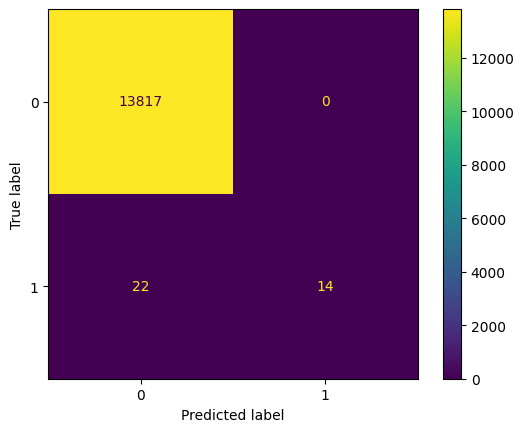

In [21]:
cm = confusion_matrix(y_test, y_pred_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()

### Random forest

In [22]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_tfidf, y_train)
y_pred_rf = clf_rf.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_rf))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       1.00      0.03      0.05        36

    accuracy                           1.00     13853
   macro avg       1.00      0.51      0.53     13853
weighted avg       1.00      1.00      1.00     13853



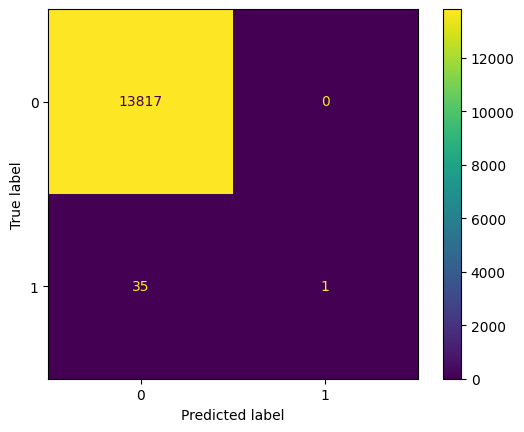

In [23]:
cm = confusion_matrix(y_test, y_pred_rf, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
disp.plot()

### Logistic Regression

In [24]:
clf_lr = LogisticRegression(class_weight='balanced')
clf_lr.fit(X_train_tfidf, y_train)
y_pred_lr = clf_lr.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_lr))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.64      0.64      0.64        36

    accuracy                           1.00     13853
   macro avg       0.82      0.82      0.82     13853
weighted avg       1.00      1.00      1.00     13853



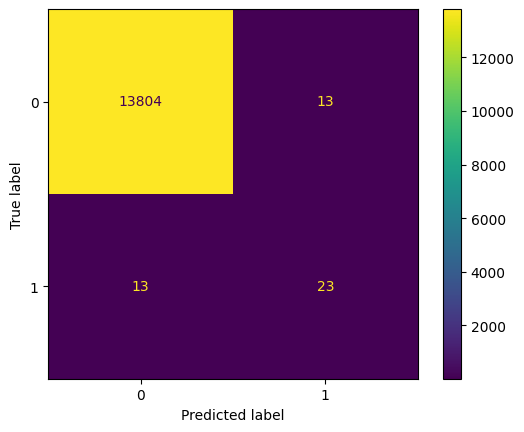

In [25]:
cm = confusion_matrix(y_test, y_pred_lr, labels=clf_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot()

### Naive bayes

In [26]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train_tfidf, y_train)
y_pred_nb = clf_nb.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_nb))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.00      0.00      0.00        36

    accuracy                           1.00     13853
   macro avg       0.50      0.50      0.50     13853
weighted avg       0.99      1.00      1.00     13853



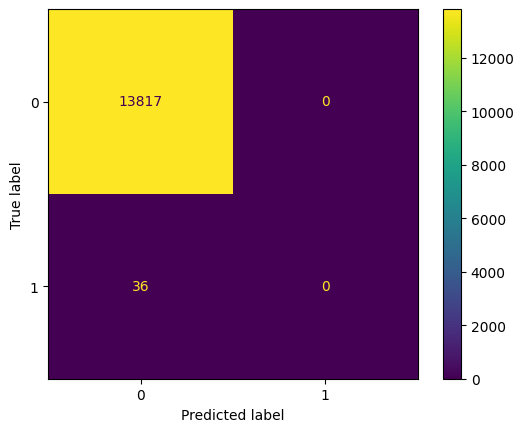

In [27]:
cm = confusion_matrix(y_test, y_pred_nb, labels=clf_nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_nb.classes_)
disp.plot()

### MLPClassifier

In [28]:
clf_mpl = MLPClassifier()
clf_mpl.fit(X_train_tfidf, y_train)
y_pred_mlp = clf_mpl.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_mlp))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.88      0.39      0.54        36

    accuracy                           1.00     13853
   macro avg       0.94      0.69      0.77     13853
weighted avg       1.00      1.00      1.00     13853



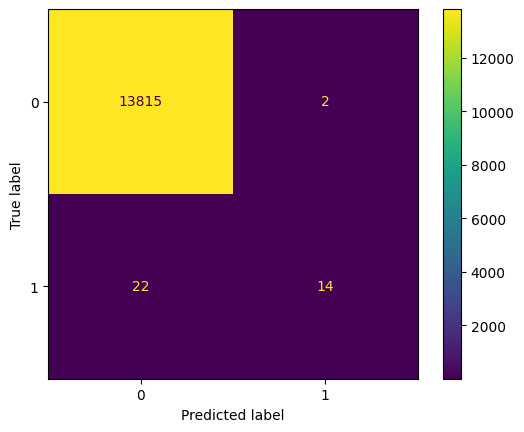

In [29]:
cm = confusion_matrix(y_test, y_pred_mlp, labels=clf_mpl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_mpl.classes_)
disp.plot()

### Ensemble

In [30]:
eclf = VotingClassifier(estimators=[('svm', clf_svm), ('lr', clf_lr)], weights=[3,2])
eclf.fit(X_train_tfidf,y_train)
y_eclf_pred = eclf.predict(X_test_tfidf)
print(classification_report(y_test, y_eclf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       1.00      0.39      0.56        36

    accuracy                           1.00     13853
   macro avg       1.00      0.69      0.78     13853
weighted avg       1.00      1.00      1.00     13853



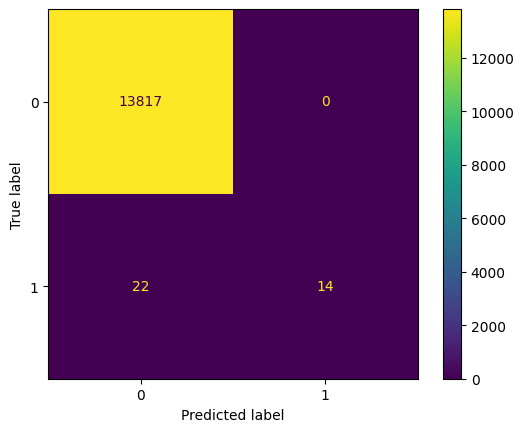

In [31]:
cm = confusion_matrix(y_test, y_eclf_pred, labels=eclf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot()

### Model comparison

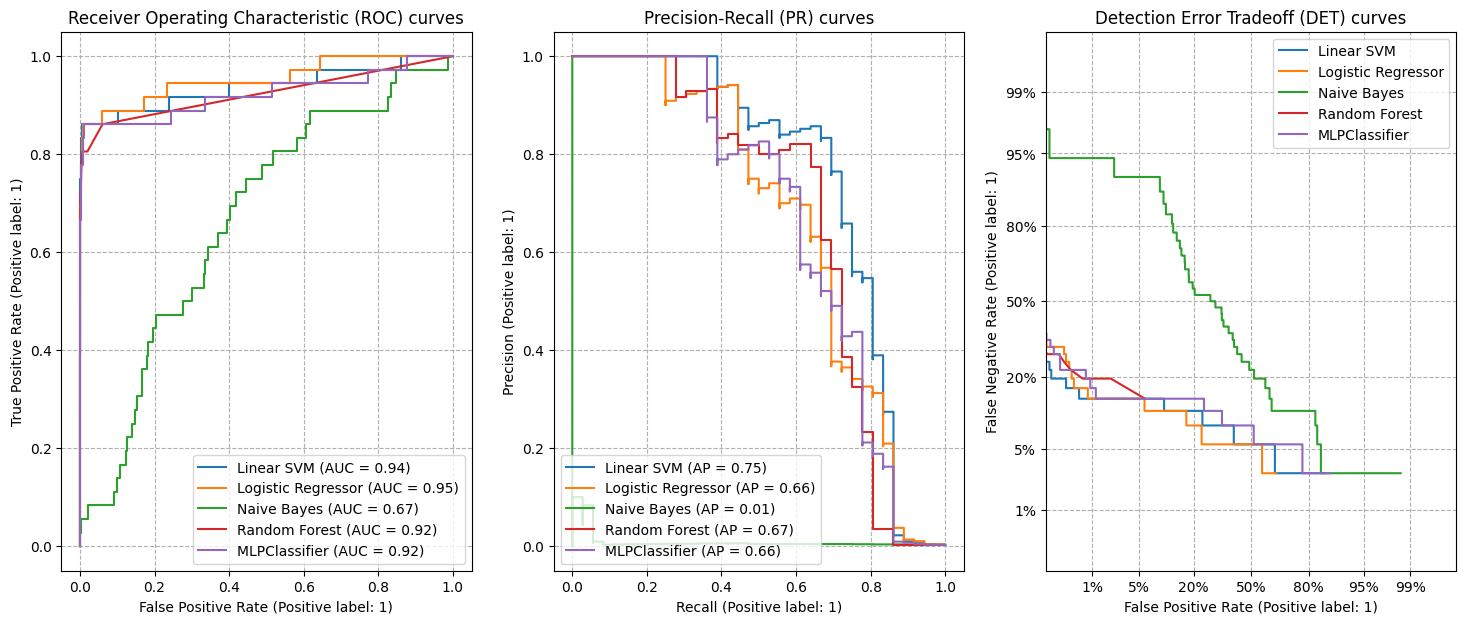

In [32]:
classifiers = {
    "Linear SVM": clf_svm,
    "Logistic Regressor": clf_lr,
    'Naive Bayes': clf_nb,
    'Random Forest': clf_rf,
    'MLPClassifier': clf_mpl
}

import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay

fig, [ax_roc, ax_pr, ax_det] = plt.subplots(1, 3, figsize=(18, 7))

for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, y_train)

    RocCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_roc, name=name)
    PrecisionRecallDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_pr, name=name)
    DetCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_pr.set_title("Precision-Recall (PR) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_pr.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

